# Introduction

## ***What if we surpise users with a higher level first gate - would it motivate them to play longer?***

In today's gaming industry, retention metrics play a crucial role in evaluating game's success. Player engagement - *especially how frequently and consistently users return - often reflects how compelling the game experience truly is.*

Based on the dataset description from Kaggle, the goal of this analysis was to determine if moving the first gate in the mobile game "*Cookie Cats*" from level 30 to level 40 would have an impact on player retention. The test aimed to understand if this change would encourage players to play for longer periods.

# Goal
By comparing these retention rates between players assigned to the `gate_30` group (gate at level 30) and the `gate_40` group (gate at level 40), the analysis evaluates whether the change in gate placement had a meaningful impact on player behavior and retention patterns.

## Main Metric
The key metrics in this analysis is the *difference* in retention rates(1-day,7-days) between two groups of `gate_40` and `gate_30`. The goal is to evaluate how moving the first gate from level 30 to level 40 impacts players' engagement and retention.

In [28]:
!pip install plotly

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import confint_proportions_2indep

##1. Loading

In [30]:
game_df = pd.read_csv("cookie_cats.csv")
game_df.head()

userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True

##2. General Overview

In [31]:
palette = ["#B3DDF2", "#66B2FF", "#4C9ED9", "#2B7A98", "#1B4965"]

In [32]:
game_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


The shape of the dataframe is **90189 rows and 5 columns** with **no NULL** values and **various data types**. There are **three categorical properties** and **2 numerical** ones.

In [33]:
game_df.duplicated().sum()

np.int64(0)

Likewise, there are **no duplicates** in this dataset.

In [34]:
Q1 = game_df.sum_gamerounds.quantile(0.25)
Q3 = game_df.sum_gamerounds.quantile(0.75)
IQR = Q3 - Q1
outliers = game_df[(game_df["sum_gamerounds"] < Q1 - 1.5 * IQR) | (game_df["sum_gamerounds"] > Q3 + 1.5 * IQR)]
print(f"There are {outliers.shape[0]} outliers in this dataset.")

There are 10177 outliers in this dataset.


##3. Properties Overview

* **userid**: A unique identifier assigned to each individual player.
* **version**: Indicates whether the player was part of the control group (`gate_30`, with a gate at level 30) or the test group (`gate_40`, with the gate moved to level 40).
* **sum\_gamerounds**: The total number of game rounds a player completed within the first 14 days after installation.
* **retention\_1**: Shows whether the player returned to play one day after installing the game.
* **retention\_7**: Shows whether the player returned to play seven days after installation.


In [35]:
print(f"Number of unique user ids: {game_df.userid.nunique()}")

Number of unique user ids: 90189


In [36]:
print(f"Unique version of the game: {game_df.version.unique()}")

Unique version of the game: ['gate_30' 'gate_40']


In [37]:
print(f"Number of unique game rounds during the first 14 days after installation: {game_df.sum_gamerounds.nunique()}")

Number of unique game rounds during the first 14 days after installation: 942


In [38]:
game_df.sum_gamerounds.describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [39]:
print(f"Unique values of retention 1 day after the installation: {game_df.retention_1.unique()}")

Unique values of retention 1 day after the installation: [False  True]


In [40]:
print(f"Unique values of retention 7 days after the installation: {game_df.retention_7.unique()}")

Unique values of retention 7 days after the installation: [False  True]


After checking the data there are indeed **90189 unique players** with two unique versions of the gates( **gate30 and gate40**).

In [41]:
gate_count = game_df.version.value_counts()
gate_count

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

In [42]:
retention_1_count = game_df.retention_1.value_counts()
retention_1_count

retention_1
False    50036
True     40153
Name: count, dtype: int64

In [43]:
retention_7_count = game_df.retention_7.value_counts()
retention_7_count

retention_7
False    73408
True     16781
Name: count, dtype: int64

In [44]:
df = pd.DataFrame()
df["Values"] = retention_1_count.index
df["retention_1"] = retention_1_count.values
df["retention_7"] = retention_7_count.values
df["total_ret7"] = retention_7_count.sum()
df["total_ret1"] = retention_1_count.sum()
df["grand_total"] = retention_1_count.sum() + retention_7_count.sum()
df

Values  retention_1  retention_7  total_ret7  total_ret1  grand_total
0   False        50036        73408       90189       90189       180378
1    True        40153        16781       90189       90189       180378

Text(0.02, 0.5, 'Count')

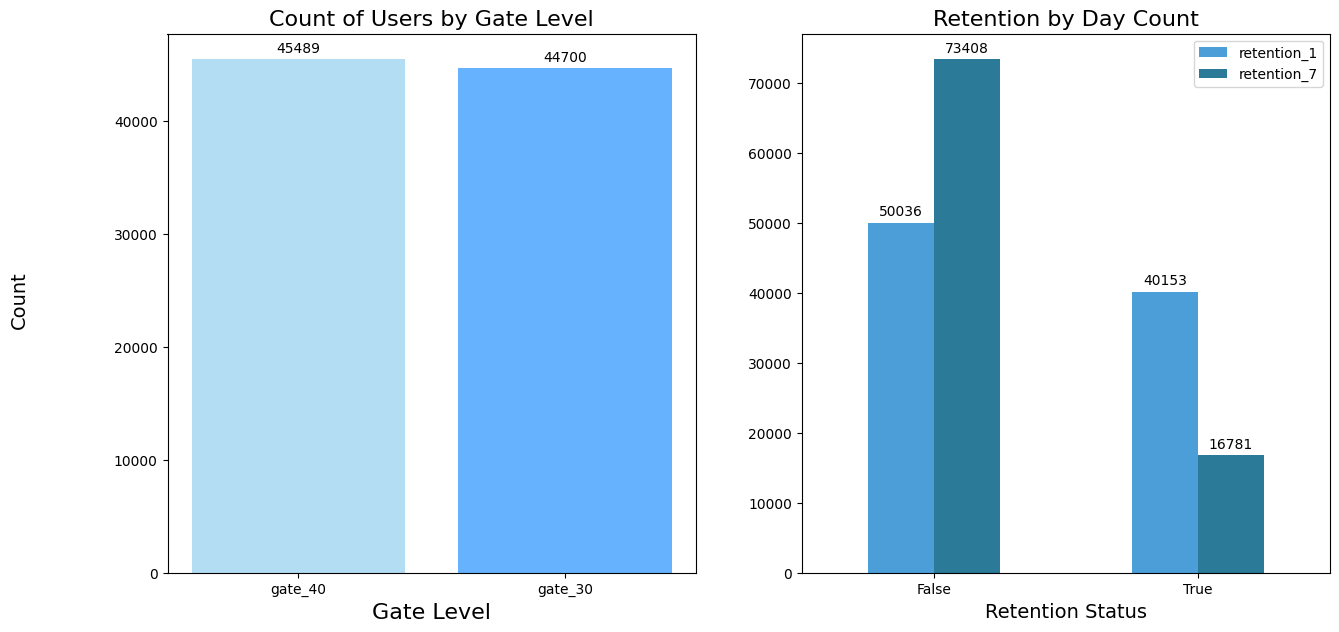

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
axs[0].bar(data=gate_count, x=gate_count.index, height=gate_count.values, color=palette[0:2])
axs[0].set_title("Count of Users by Gate Level", fontsize=16)
axs[0].set_xlabel("Gate Level", fontsize=16)

df[["retention_1", "retention_7"]].plot(kind="bar", ax=axs[1], color=palette[2:4])
axs[1].set_xticks(df.index)
axs[1].set_xticklabels(df.Values, rotation=0)
axs[1].set_title("Retention by Day Count", fontsize=16)
axs[1].set_xlabel("Retention Status", fontsize=14)

num = [0, 1]
for n in num:
    for container in axs[n].containers:
        axs[n].bar_label(container, padding=3)
fig.supylabel("Count", fontsize=14)

Given the findings from the data mapping above, players were **disributed nearly equally between gate_30 and gate_40** version, indicating a **successful random assignment**. Additionally, a higher number of players did not return after 7 days compared to 1 day.Conversely, among those who were retained, more players returned on dat 1 than on day 7. This pattern suggests that **the longer the time elapsed** since the last game session, **the lower the likelihood of a player returning**.

In [46]:
retention_counts = game_df.groupby("version")[["retention_1", "retention_7"]].sum()
fig = px.bar(retention_counts, barmode="group", text_auto=True, color_discrete_sequence=palette)
fig.update_layout(
    title=dict(
        text="Retention Counts by Gate Version",
        x=0.5,
        xanchor="center",
        font_size=18
    ),
    xaxis_title="Gate Version",
    yaxis_title="Number of Players",
    font=dict(size=14),
    legend_title="Retention Type"
)

Inferring from data display, more players returned to the game on Day 1 than on Day 7, regardless of gate version. Players in the `gate_40` group had slightly higher retention on Day 1, while those in the `gate_30` group showed slightly higher retention on Day 7.


##4. A/B Test
A - gate_30 quantity

B - gate_40 quantity

This A/B test aims to investigate the impact of moving the first game gate from level 30 (`gate_30`) to level 40 (`gate_40`) on player retention to determine **which gate placement is more effective at retaining players after installation.**

/tmp/ipython-input-47-328999214.py:10: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




Text(0, 0.5, 'Log-Transformed Game Rounds Count')

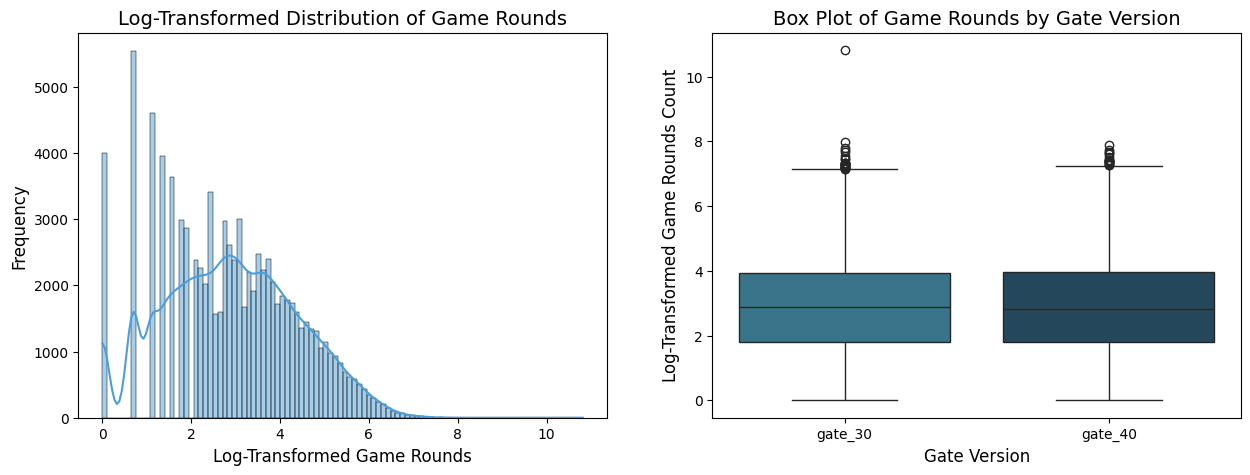

In [47]:
d = game_df
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
d["var"] = np.log1p(game_df["sum_gamerounds"])
d["percentage"] = d["sum_gamerounds"] / d["sum_gamerounds"].sum()
sns.histplot(data=d, x="var", bins=100, kde=True, color=palette[2], ax=axs[0])
axs[0].set_title("Log-Transformed Distribution of Game Rounds", fontsize=14)
axs[0].set_xlabel("Log-Transformed Game Rounds", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize=12)

sns.boxplot(data=d, x="version", y="var", palette=palette[3:5], ax=axs[1])
axs[1].set_title("Box Plot of Game Rounds by Gate Version", fontsize=14)
axs[1].set_xlabel("Gate Version", fontsize=12)
axs[1].set_ylabel("Log-Transformed Game Rounds Count", fontsize=12)

The sum_gamerounds data is right-skewed, meaning **most players played few rounds, while a few played many**. There are in total 10177 outliers with very high game rounds, possibly due to **power users or data errors**. Despite outliers, the **distribution of game rounds appears similar between the gate_30 and gate_40 group**s.

### Requirements for Chi-Square Test
1. Categorical Data
2. Large Enough Sample
3. Random Sampling
4. Independency of Data





### Data Type, Randomization and Independence
Variables of gate versions `gate_30` and `gate_40` are both binary equally each player on entering game was always randomly assigned. Additionally, each player's status is unique which supports the independency of the data.

### Large Enough Sample


In [48]:
gate_counts = game_df['version'].value_counts()

for version in gate_counts.index:
    n = gate_counts[version]

    ret1_t = game_df[(game_df.version == version) & (game_df.retention_1 is True)].shape[0]
    ret7_t = game_df[(game_df.version == version) & (game_df.retention_7 is True)].shape[0]

    p1 = ret1_t / n
    p7 = ret7_t / n

    if n * p1 >= 5 and n * (1 - p1) >= 5:
        print(f"Sample size for retention_1 in {version} is large enough.")
    if n * p7 >= 5 and n * (1 - p7) >= 5:
        print(f"Sample size for retention_7 in {version} is large enough.")

### Chi-Square Test
**Null Hypothesis (H0)**: There is no statistically significant difference in the proportion of players who retain (either after 1 day or 7 days) between the gate_30 and gate_40 versions. **In other words, the gate version has no effect on player retention**.

**Alternative Hypothesis (H1)**: There is a statistically computed difference in the proportion of players who return (either after 1 day or 7 days) between the gate_30 and gate_40 types. **Consequently, the gate version does have an influence on player retention.**

In [49]:
def con_t(ret) -> pd.DataFrame:
    """
    Create a contigency table to perform statistical computations.
    :param ret: retention type
    :type ret: str
    :return: contigency table
    :rtype: pd.DataFrame
    """
    con_table = pd.crosstab(game_df["version"], game_df[ret])
    return con_table

In [50]:
def chi(con_table) -> None:
    """
    Quantifies and prints to the screen chi-square statistic,p-value, degrees of freedom, expected count.
    :param con_table: contigency table
    :type con_table: pd.DataFrame
    :return: None
    :rtype: None
    """
    chi2, p, dof, expected = chi2_contingency(con_table)
    print(f"Chi-Square Statistic: {chi2:.3f}")
    print(f"P-value: {p:.3f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"Expected count: {expected}")

In [51]:
retention = ["retention_1", "retention_7"]
for r in retention:
    print("-" * 50)
    print(f"Retention period: {r[-1]} days")
    chi(con_t(r))

--------------------------------------------------
Retention period: 1 days
Chi-Square Statistic: 3.159
P-value: 0.076
Degrees of Freedom: 1
Expected count: [[24799.13514952 19900.86485048]
 [25236.86485048 20252.13514952]]
--------------------------------------------------
Retention period: 7 days
Chi-Square Statistic: 9.959
P-value: 0.002
Degrees of Freedom: 1
Expected count: [[36382.90257127  8317.09742873]
 [37025.09742873  8463.90257127]]


**For 1-day retention**, the p-value (0.076) is > 0.05, so fail to reject the null hypothesis. **There's no significant difference in 1-day retention** between `gate_30` and `gate_40`.

**For 7-day retention**, the p-value (0.002) is < 0.05, so reject the null hypothesis. **There's a significant difference in 7-day retention** between the two groups, suggesting the gate level impacts longer-term retention.

### Confidence Intervals

In [52]:
def ci(ret) -> None:
    """
    Calcutes and prints to the screen confidence intervals for retention rates by gate version.
    :param ret: retention type
    :type ret: str
    :return: None
    :rtype: None
    """
    ret_gate30 = game_df[(game_df["version"] == "gate_30") & (game_df[ret] is True)].shape[0]
    ret_gate40 = game_df[(game_df["version"] == "gate_40") & (game_df[ret] is True)].shape[0]
    total_gate30 = game_df[game_df["version"] == "gate_30"].shape[0]
    total_gate40 = game_df[game_df["version"] == "gate_40"].shape[0]

    ci_low, ci_upp = confint_proportions_2indep(count1=ret_gate40, nobs1=total_gate40, count2=ret_gate30, nobs2=total_gate30, method="wald")
    print(f"95% Confidence Interval:({ci_low:.3f}, {ci_upp:.3f})")

In [53]:
def bootstrap_propor_diff(ret, n_iterations=1000) -> None:
    """
    Computes and prints to the screen bootstrap confidence interval for retention rates by gate version.
    :param ret: retention type
    :type ret: str
    :param n_iterations: number of iterations for bootstrap
    :type n_iterations: int
    :return: None
    :rtype: None

    """
    diffs = []
    group_30 = game_df[game_df["version"] == "gate_30"][ret].values
    group_40 = game_df[game_df["version"] == "gate_40"][ret].values
    for _ in range(n_iterations):
        boot_30 = np.random.choice(group_30, size=len(group_30), replace=True)
        boot_40 = np.random.choice(group_40, size=len(group_40), replace=True)

        p30 = boot_30.mean()
        p40 = boot_40.mean()
        diffs.append(p40 - p30)

    lower = np.percentile(diffs, 2.5)
    upper = np.percentile(diffs, 97.5)

    print(f"Bootstrap 95% Confidence Interval:({lower:.3f}, {upper:.3f})")

In [54]:
ret = ["retention_1", "retention_7"]
for r in ret:
    print("-" * 100)
    print(f"Retention period (gate_40 - gate_30) for {r[-1]} days:\n")
    ci(r)
    bootstrap_propor_diff(r)

----------------------------------------------------------------------------------------------------
Retention period (gate_40 - gate_30) for 1 days:

95% Confidence Interval:(0.000, 0.000)
Bootstrap 95% Confidence Interval:(-0.012, 0.001)
----------------------------------------------------------------------------------------------------
Retention period (gate_40 - gate_30) for 7 days:

95% Confidence Interval:(0.000, 0.000)
Bootstrap 95% Confidence Interval:(-0.013, -0.003)


**Interpretation of Confidence Intervals:**

*   **1-day retention:** The confidence and bootstrap intervals have similar values as for the difference in 1-day retention between `gate_40` and `gate_30` include zero. This aligns with the Chi-Square test result and suggests that there is no statistically significant difference in 1-day retention between the two groups.
*   **7-day retention:** The confidence and bootstrap intervals are quite equal and the difference in 7-day retention between `gate_40` and `gate_30` does not include zero. This reinforces the Chi-Square test result and indicates a statistically significant difference in 7-day retention between the two groups. Since the interval is negative, it suggests that the `gate_40` group has *lower* 7-day retention compared to the `gate_30` group.

##5. Possible Inaccuracies

As highlighted, the analysis might have potential inaccuracies due to the following data distortions:

* **Outliers:** The presence of outliers in `sum_gamerounds` could skew the results and distort the analysis of player engagement.
* **Short Retention Period:** Analyzing only 1-day and 7-day retention might not be sufficient to understand the long-term impact of the gate placement. Player behavior could be influenced by various external factors not captured in this short timeframe.


##6. Final Conclusions

This A/B test examined the impact of changing the first gate in Cookie Cats from level 30 (`gate_30`) to level 40 (`gate_40`). The player assignment was balanced between groups, ensuring the randomization was effective.

**Retention Overview**:
As expected, **overall retention decreased over time**. More players returned one day after installation than after seven days, a common trend in mobile games.

**1-Day Retention**:
Statistical analysis using a Chi-square test and confidence intervals showed no significant difference in 1-day retention between the two groups. This suggests that **moving the gate had little to no impact on short-term player behavior**.

**7-Day Retention**:
In contrast, the analysis of 7-day retention revealed a statistically significant difference. Players in the gate_40 group were less likely to return after a week, indicating that **moving the gate negatively affected long-term engagement**.



## **Answer To Question**

### "What if we surpise users with a higher level first gate - would it motivate them to play longer?" -
The results suggest that while **gate placement did not influence immediate retention, it did affect longer-term player behavior.** Keeping the gate at level 30 appears to better support 7-day retention.

*Further analysis using longer timeframes and controlling for outliers may help confirm and expand on these findings.*


##7. Potential Improvements
1. The gate’s position likely affects early-game pacing, so **reviewing how players progress through these initial levels** could help reduce churn and improve engagement.
2. Additionally, **examining player behavior around the gate**—such as when and how players encounter it—can provide insights into the retention drop observed in the `gate_40` group.
3. **Extending retention tracking beyond 7 days** will also be important to understand the longer-term effects of gate placement.
